# Introduction

本文是谷歌发表的文章，针对nlp里的机器翻译问题，提出了一种被称为”Transformer”的网络结构，基于**注意力机制**。文章提出，以往nlp里大量使用RNN结构和encoder-decoder结构，RNN及其衍生网络的缺点就是慢，问题在于前后隐藏状态的依赖性，无法实现并行，而谷歌最新的只基于Attention的Transformer模型摒弃了固有的定式，依赖注意力机制，挖掘输入和输出之间的关系,并没有用任何CNN或者RNN的结构。该模型可以高度并行地工作，所以在提升翻译性能的同时训练速度也特别快。

# Background

在此之前，针对机器翻译这个领域，为了应对RNN无法并行问题，已经有过一些使用CNN的解决方案了，例如谷歌的ByteNet，Facebook的FairSeq等等。自注意力机制（Self-attention）能够把输入序列上不同位置的信息联系起来，然后计算出整条序列的某种表达，目前自注意力机制主要应用于阅读理解、提取摘要、文本推论等领域。

# model

大多数自然语言转换模型都包含一个encoder-decoder结构，模型的输入是一个离散符号序列（symbol）x=(x1,x2,⋯,xn)x=(x1,x2,⋯,xn)，encoder负责将它映射成连续值序列z=(z1,z2,⋯,zn)z=(z1,z2,⋯,zn)。而给定zz，decoder负责生成一个输出符号序列y=(y1,y2,⋯,ym)y=(y1,y2,⋯,ym)。模型是自回归的，即之前生成的输出会作为额外的输入，用于生成下一个输出。

# Encoder与Decoder堆叠
## 模型输入
编码器和解码器的输入就是利用学习好的embeddings将tokens（一般应该是词或者字符）转化为dmodel 维向量。对解码器来说，利用线性变换以及softmax函数将解码的输出转化为一个预测下一个token的概率。
## Encoder
Transformer模型的Encoder由6个基本层堆叠起来，每个基本层包含两个子层，第一个子层是一个多头的注意力机制，第二个是一个全连接前向神经网络。对两个子层都引入了残差边以及layer normalization，模型所有的支层以及embedding层的输出维度都是dmodel=512。
## Decoder
Transformer模型的Decoder也由6个基本层堆叠起来，每个基本层除了Encoder里面的那两个以外，还增加了一层**Masked**注意力机制，同样引入残差边以及layer normalization。
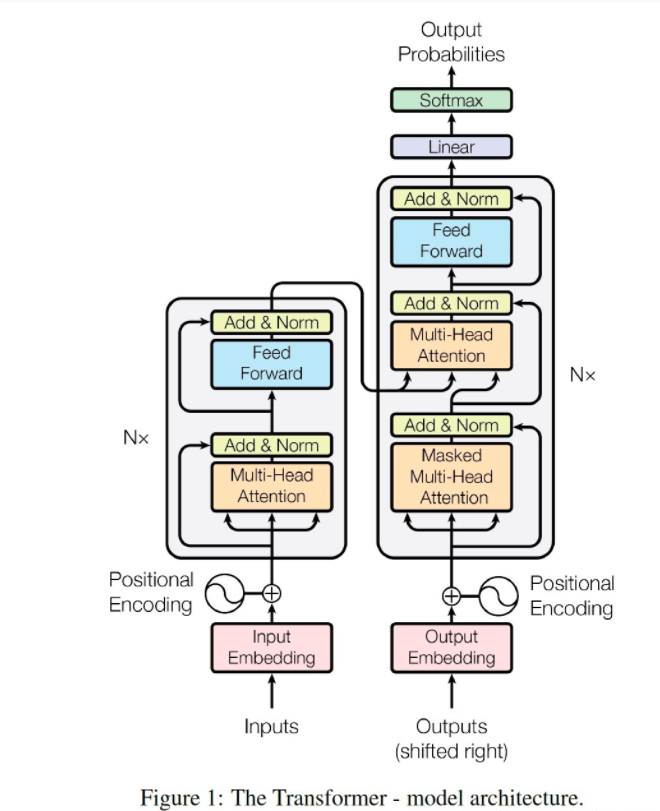

# 注意力机制
注意力机制（Attention）简单来说就是给定一个查找（query）和一个键值表（key-value pairs)，将query映射到正确的输入的过程。此处的query、key、value和最终的输出都是向量。输出往往是一个加权求和的形式，而权重则由query、key和value决定。实际操作中，attention函数是在一些列queries上同时进行的，将这些queries并在一起形成一个矩阵Q 同时keys以及values也并在一起形成了矩阵K 以及V。
## Additive Attention
### Scaled Dot-Product Attention
输入包含$d_k$维的query和key，以及$d_v$维的value。通过计算query和各个key的点积，除以$\sqrt{d_k}$归一化(Scaled)，然后经过softmax激活变成权重，最后再乘value。点积注意力机制的优点是速度快、占用空间小。$$Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})$$
文中还讨论了点乘和additive attention(加法)别，additive的attention用了一个单层的前馈网络，理论上二者的复杂度是差不多的，但是实际上点乘更快而且空间上更有效率，因为点乘可以利用高度优化了的矩阵乘法代码来实现。
当$d_k$比较小时，两个机制的效果几乎差不多，而在$d_k$比较大的时候，additive的attention效果比没有scale操作的点乘attention效果好。作者怀疑这是因为the dot products growing too large in magnitude to result in useful gradients after applying the softmax function，所以作者用了scale这个操作来规模化点乘。
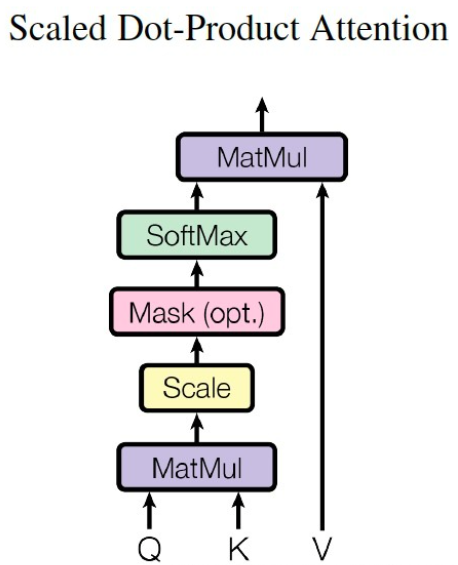
### Multi-Head Attention
这个应该是本文最核心的部分。本文结构中的Attention并不是简简单单将一个点乘的attention应用进去。作者发现先对queries，keys以及values进行h次不同的线性映射(Linear)效果特别好。(paper取8个)不同的线性变换分别将$d_{model}$维的$d_{key}$、$d_{value}$和$d_{query}$映射成$d_k$、$d_k$维和$d_v$维，然后再代入注意力机制，产生总共h×$d_v$维输出，然后拼起来，再用一个线性变换得到最终的输出。     $\text { 这里映射的参数矩阵， } W_{i}^{Q} \in \mathbb{R}^{d_{\text {modet }} d_{k}}, W_{i}{ }^{K} \in \mathbb{R}^{d_{\text {modet }} d_{k}}, W_{i}^{V} \in \mathbb{R}^{d_{\text {modet }} d_{v}}$。     
本文中对并行的attention层（或者成为头）使用了 h=8的设定。其中每层都设置为$d_k = d_v = d_{model}/h=64。$由于每个头都减少了维度，所以总的计算代价和在所有维度下单头的attention是差不多的。
$$head_i = Attention(QW^{Q}_{i},KW^{K}_{i},VW^{V}_{i})$$
$$MultiHead(Q,K,V) = Concat(head_1,⋯,head_h)W^O$$
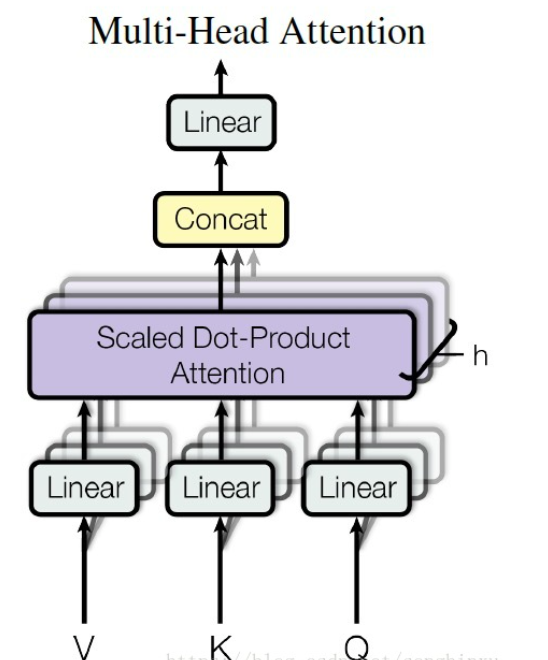
## 本文使用的注意力机制
本文使用的是Multi-Head Attention，具体体现在三个方面。

* 在“encoder-decoder attention”层中，query来自前一个decoder层，而key和value是encoder的输出。这允许decoder的每个位置都去关注输入序列的所有位置。这个类似于很多已经提出的seq-to-seq模型所使用的attention机制。
* encoder包含self-attention层，在self-attention层中所有的key、value和query都来自前一层的encoder。这样encoder的每个位置都能去关注前一层encoder输出的所有位置。
* 类似的，decoder中的self-attention层也是一样。不同的是在scaled点乘attention操作中加了一个mask的操作（设置为负无穷），这个操作是保证softmax操作之后不会将非法的values连到attention中（个人理解，比如你这一位置query attention的values不能有这一位置之后的values的信息，只能有该位置前面的values）。
## 前向神经网络
这是一个 Position-wise 前向神经网络，encoder和decoder的每一层都包含一个前向神经网络，激活函数顺序是线性、RELU、线性。每个位置（position）上的线性变换是一样的，但是不同层与层的参数是不一样的。该网络的输入和输出维度都是$d_{model}$，不过中间层的维度是2048。
$$FFN(x) = max(0,xW_1+b_1)W_2+b_2$$
## 位置编码
由于本文的模型结构没有使用任何递归结构或卷积结构，为了让模型能利用输入序列的顺序信息，必须引入某种能表达输入序列每个部分的绝对或相对位置的信息才行。文章采取的方法是位置编码（positional encoding），在送入encoder和decoder之前，在输入embeddings的基础上加了一个“位置编码”。位置编码和embeddings由同样的维度都是$d_{model}$所以两者可以直接相加。有很多位置编码的选择，既有学习到的也有固定不变的。编码后的向量维度是$d_{model}$。具体来说，本文采用正弦和余弦函数进行编码。pos是位置，i是维度。
$$
\begin{gathered}
P E(p o s, 2 i)=\sin \left(p o s / 10000^{2 i / d_{m o d e l}} \right) \\
P E(p o s, 2 i+1)=\cos \left(p o s / 10000^{2 i / d_{m o d e l}} \right)
\end{gathered}
$$

# 为什么使用selr-attention
从三个方面去对比self-attention和递归结构、卷积结构的优劣性，首先是每一层的计算复杂度，其次是能够被并行的计算量，最后是网络中长期依赖的路径长度。对比显示，self-attention表现最好。为了提升在长序列上的计算性能，self-attention应该改被限制（restrict）在一个size大小为r 的邻域内，这样可以将最大路径长度增加到$O(n/r)$ ，至于具体如何去做作者说在未来工作中会研究。
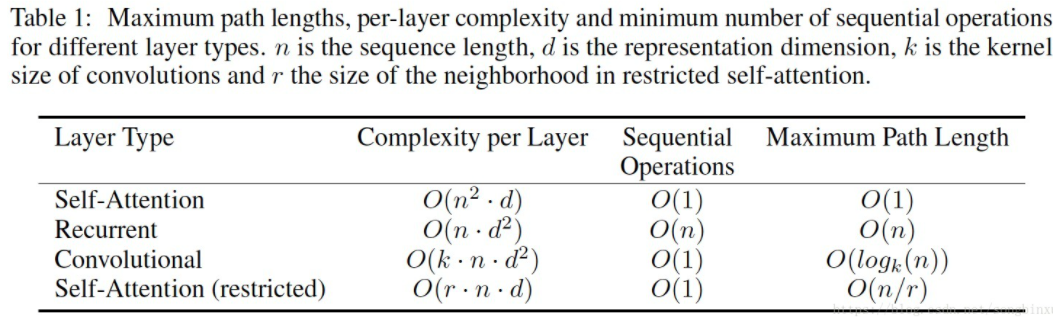

# 训练
训练数据使用WMT English-German数据集，包含450w对语句。句子都被编码过了，使用了一个大小约37000个token的字典。样本被分为若干个batch，每个batch大概25000个token，每个batch中的句子长度保持基本一致。硬件上使用了8块GPU。Optimizer使用了Adam。过拟合方面使用了dropout和Label Smoothing。

# 结果
不论是英语-德语还是英语-法语的翻译任务，对比之前的一些模型，本文提出的模型都达到更好的BELU值，同时Training Cost也最低。
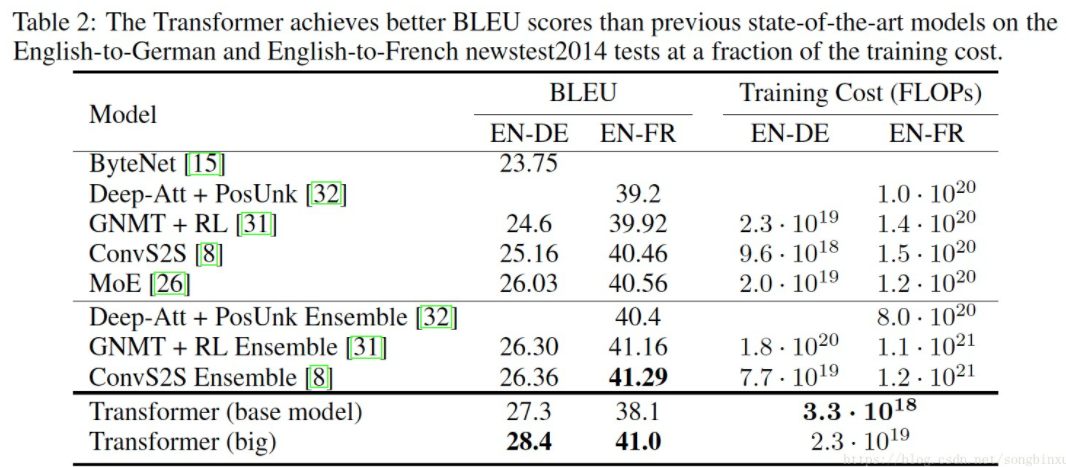

# 论文10问
## Q1 论文试图解决什么问题？
减少顺序计算的目标形成了扩展神经GPU、ByteNet和ConvS2S的基础，所有这些都使用卷积神经网络作为基本构建块，并行计算所有输入和输出位置的隐藏表示。在这些模型中，和来自两个任意输入或输出位置相关联的信号所需的操作数量在（输入输出）位置之间的距离上增加，ConvS2S线性增长，ByteNet线数增长。这使得学习远程位置之间的依赖关系更加困难。（内存约束限制）
本文中，在Transformer中，上述的线性增加关系减少为常数级别的操作，尽管代价是由于平均注意加权位置而降低有效分辨率，这是一个我们与Multi-Head Attention抵消的影响。
总结来说，传统的·基于RNN的Seq2Seq model难以处理长序列的句子、无法实现并行以及存在对齐问题。
## Q2 这是否是一个新的问题？
不是。
RNN 的明显缺点之一就是无法并行，因此速度较慢，这是递归的天然缺陷。递归模型通常沿着输入和输出序列的符号位置计算。将位置与步骤在计算时间中对齐，它们生成一系列隐藏状态ht，作为前一个隐藏状态ht−1和位置t的输入的函数。这种固有的顺序特性排除了训练示例中的并行化，这在更长的序列长度时变得关键，因为内存约束限制了示例之间的批处理。最近的工作通过分解的技巧和条件计算显著提高了计算效率，同时也提高了模型的性能。然而，序列计算的基本约束条件仍然存在。
## Q3 这篇文章要验证一个什么科学假设？
Transformer是第一个完全依赖于自我注意力来计算其输入和输出表示的转导模型，而不使用序列对齐的RNN或卷积。同时也要验证本文提出的Transformer性能优于其他模型。
## Q4 有哪些相关研究？如何归类？谁是这一课题在领域内值得关注的研究员？
使用RNN层来完成Seq2Seq，使用CNN层来完成Seq2Seq，使用attention层来完成Seq2Seq。

减少顺序计算的目标也形成了扩展神经GPU、ByteNet和ConvS2S的基础，所有这些都使用卷积神经网络作为基本构建块，并行计算所有输入和输出位置的隐藏表示。

the Extended Neural GPU： Łukasz Kaiser and Samy Bengio. Can active memory replace attention? In Advances in Neural Information Processing Systems, (NIPS), 2016.

ByteNet：Nal Kalchbrenner, Lasse Espeholt, Karen Simonyan, Aaron van den Oord, Alex Graves, and Koray Kavukcuoglu. Neural machine translation in linear time. arXiv preprint arXiv:1610.10099v2,
2017.

ConvS2S：Jonas Gehring, Michael Auli, David Grangier, Denis Yarats, and Yann N. Dauphin. Convolutional sequence to sequence learning. arXiv preprint arXiv:1705.03122v2, 2017.
## Q5 论文中提到的解决方案之关键是什么？
提出Transformer，完全基于attention的序列转换模型，用multi-headed self-attention取代了encoder-decoder架构中最常用的recurrent layers。

提出Position Embedding， 能提高准确率、减弱过拟合
## Q6 论文中的实验是如何设计的？
首先提出attention概念和定义，因为提出的Transformer是完全基于attention的序列转换模型。

然后对attention机制的完善，提出了Multi-Head Attention，即是多做几次相同的事情，参数独立使用，然后把结果拼接。

接着提出了Self Attention，即寻找序列内部的联系。Google结合了Self和Multi-Head Attention。

又因为序列顺序很重要，所以引入了Position Embedding，将位置编号，每个编号对应一个向量，对每个词引入了位置信息。

然后使用数据集来检测提出的模型的性能优越性
## Q7 用于定量评估的数据集是什么？代码有没有开源？
我们在标准的WMT2014英德数据集上，由约450万句子对进行了训练。句子使用编码为字节对的[3]进行编码，它具有大约37000个令牌的共享源数据词汇表。对于英法词汇，我们使用了显著更大的WMT2014英法数据集，由3600万个句子组成，并将令牌划分为32000个字片词汇表[38]。句子对按近似的序列长度组合在一起。每个训练批包含一组句子对，其中包含大约25000个源令牌和25000个目标令牌。
开源了[The code we used to train and evaluate our models is available at] (https://github.com/tensorflow/tensor2tensor.)
## Q8 论文中的实验及结果有没有很好地支持需要验证的科学假设？
有
1、在English-to-German和English-to-French的任务上都优于以往模型， 而且训练速度更快。
2、我们在表4中的结果显示，尽管缺乏特定任务的调优，我们的模型表现得令人惊讶，除了递归神经网络语法外，比之前报道的所有模型产生更好的结果。
3、与RNN序列对序列模型相比，即使只在《华尔街日报》训练集上进行训练，变压器的性能也优于贝克利解析器。

但是，Attention 的计算量并不低。如包含了两次序列自身的矩阵乘法，这两次矩阵乘法的计算量都是 $O(n^2)$ 的，当序列足够长，计算量便很大。
## Q9 这篇论文到底有什么贡献？
表明了内部注意力在机器翻译（甚至是一般的 Seq2Seq 任务）的序列编码上是相当重要的，而之前关于 Seq2Seq 的研究基本都只是把注意力机制用在解码端。

在这项工作中，我们提出了transformer，第一个完全基于注意的序列转导模型，用多头自我注意取代了编码器-解码器架构中最常用的循环层。对于翻译任务，变压器的训练速度可以明显快于基于循环层或卷积层的架构。在WMT2014英德语和WMT2014英法翻译任务中，我们实现了一种新的艺术状态。在前一项任务中，我们最好的模型甚至优于所有以前报告的集合。
## Q10 下一步呢？有什么工作可以继续深入？
计划将基于attention的模型应用于其他任务。 计划将Transformer扩展到除文本之外的涉及输入和输出模式的问题，并研究局部的、受限的attention机制，以有效地处理图像、音频和视频等大型输入和输出。 让生成具有更少的顺序性是我们的另一个研究目标。

并非所有问题都需要长程的、全局的依赖的，也有很多问题只依赖于局部结构，这时候用纯 Attention 也不大好，之后可以将attention和RNN和CNN结合。